`xlsxwriter` needs to be installed

In [1]:
#seting up the working directory to the current directory
import os
os.chdir(os.getcwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from scipy.optimize import curve_fit

#for excel export
import xlsxwriter

#for plot smoothing
#from scipy.interpolate import spline
from scipy.interpolate import splev, splrep

#for autocorreltation 
# from interpacf import interpolated_acf, dominant_period

#FFT
from numpy import fft
import scipy.fftpack
from scipy.interpolate import UnivariateSpline
import scipy.interpolate as inter

from scipy.interpolate import spline
from scipy.interpolate import splev, splrep

# import seaborn as sns
# sns.set()
from scipy import stats

In [4]:
speeds=[10,30,50,100,150,200,300,400,600,800,1000,1400,1800]
weights=[41,53,65,77,89,136,184,232]

In [5]:
def func_lin(x,a,b):
    return a*x+b

def func_exp(x,a,b,c):
    return a*np.exp(b*x)+c

def func_hess(x,a,b,c):
    return a+b/(1+(x/c)**2)

def func_arm(x,a,b,c):
    return a+b*np.exp(-(x/c)**2)

FFT using Numpy:

In [10]:
%matplotlib qt

# writer = pd.ExcelWriter('spectral_FFT_np.xlsx', engine='xlsxwriter')


for w in weights:
    dfs2=pd.DataFrame(columns=['freq','mag'],index=speeds)
    for j, s in enumerate(speeds):
        dfs = pd.read_excel("friction coeficient_"+str(w)+"g.xls", sheet_name=j+3)
        dfs.columns=['time','strain','force','work']
        dfs=dfs.drop(dfs.index[[0,1]])



        # dfs.sort_values(by=['strain'],inplace=True)
        
        #removing anytheing before the max
        dfs.drop(dfs.index[:dfs['force'].astype(float).idxmax()],inplace=True)
        #removing anything after the strain is constant
        dfs=dfs[(dfs['strain'].iloc[-1]-dfs['strain'])>0.001]



        force=dfs['force'].values.astype(float)
        strain=dfs['strain'].values.astype(float)


        N=force.size
        # L1=strain[1]-strain[0] # sample rate
        # L2=(strain[-1]-strain[0])/N

        # print(L1,',',L2)
        popt, pcov = curve_fit(func_lin, dfs.index, strain)
        # print(popt)
        L=popt[0]

        # plt.scatter(dfs.index, strain, s=2)
        # plt.plot(dfs.index, popt[0]*dfs.index+popt[1])

        # 1/L = frequency
        f = np.linspace(0, 1 / L, N)

        # # plt.plot(strain, force)

        # #FFT
        # #numpy
        sp = np.fft.fft(force-force.mean())
        # freq = np.fft.fftfreq(strain.shape[-1])

        # # plt.plot(freq, np.abs(sp))

    #     print(speeds[j],',',f[(np.abs(sp)[:N // 2]).argmax(axis=0)],',',np.abs(sp).max()* 1 / N)
        dfs2['freq'][s]=f[(np.abs(sp)[:N // 2]).argmax(axis=0)]
        dfs2['mag'][s]=np.abs(sp).max() / N
    # dfs2
    plt.plot(dfs2.index.values.astype(float), dfs2['mag'],label=str(w))
    # plt.bar(f[:N // 2], np.abs(sp)[:N // 2] * 1 / N, width=0.01)  # 1 / N is a normalization factor
#     plt.plot(f[:N // 2], np.abs(sp)[:N // 2] / N)  # 1 / N is a normalization factor
#     dfs2.to_excel(writer, sheet_name=str(w))


# plt.xlim(0,)

# plt.ylabel("Frequency (1/mm)")
plt.ylabel("Amplitude (N)")
plt.xlabel("Speed (mm/min)")
plt.legend(title="Normal force (gram)")
plt.show()


# writer.save()

In [47]:
#follwoing this page: https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python

# %matplotlib inline
%matplotlib qt

writer = pd.ExcelWriter('spectral_FFT_scipy.xlsx', engine='xlsxwriter')

# w = 41
# j = 0
for w in weights:
    dfs2=pd.DataFrame(columns=['mean', 'per','mag'],index=speeds)
    for j, s in enumerate(speeds):
        dfs = pd.read_excel("friction coeficient_"+str(w)+"g.xls", sheet_name=j+3)
        dfs.columns=['time','strain','force','work']
        dfs=dfs.drop(dfs.index[[0,1]])



        # dfs.sort_values(by=['strain'],inplace=True)

        #removing anytheing before the max
        dfs.drop(dfs.index[:dfs['force'].astype(float).idxmax()],inplace=True)
        #removing anything after the strain is constant
        dfs=dfs[(dfs['strain'].iloc[-1]-dfs['strain'])>0.001]


        force=dfs['force'].values.astype(float)
        mean = force.mean()
        
        force -= mean
        strain=dfs['strain'].values.astype(float)
        strain -= strain[0]
        # time=dfs['time'].values.astype(float)*60

        #number of sample points
        N=force.size



        #sample spacing
        popt, pcov = curve_fit(func_lin, np.arange(N), strain)
        L=popt[0]

        # print(strain[-1])
        # print(L * N +popt[1])
        # plt.plot(np.arange(N), strain)
        # plt.plot(np.arange(N), L*np.arange(N)+popt[1])

        # plt.subplot(2, 1, 1)
        # plt.plot(strain, force)
        # plt.grid()




        force_f = 2.0/N *np.abs(scipy.fftpack.fft(force))
        freq = np.linspace(0.0, 1.0/(2.0*L), N//2) 



        x = 1/freq[1:]
        # print(x<3)
        xlim = (5-2)*(s-250)/(1800-250)+2
        xp = x[x<xlim]
        # print(x)
        y = force_f[1:N//2]
        yp = y[x<xlim]
        # spl = UnivariateSpline(x, y)
        # spl = inter.InterpolatedUnivariateSpline (x, y)
        # spl = inter.UnivariateSpline(x[::-1], y[::-1], s=0.00001)

        dfs2['per'][s]=xp[yp.argmax()]
        dfs2['mag'][s]=yp.max()
        dfs2['mean'][s] = mean

    #     print(xp[yp.argmax()], ', ', yp.max())

        # plt.subplot(2, 1, 2)
        # plt.xlim(0,3)
        # plt.semilogx(x, spl(x))
        # plt.semilogx(x,  y)
        # plt.plot(x, y)
    #     plt.plot(xp, yp, label = str(s))
        # plt.grid()
        #     plt.semilogx(x, np.sort(y), label = str(s))

        dfs2.to_excel(writer, sheet_name=str(w))


# plt.plot(dfs2.index,dfs2['mag'])
# plt.legend()
# plt.show()

writer.save()

5.548849244801261e-05
0.0007189656047889978
0.004104907784862641


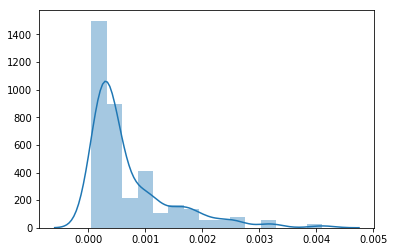

In [54]:
print(stats.mode(y)[0][0])
print(y.mean())
print(y.max())
sns.distplot(y)

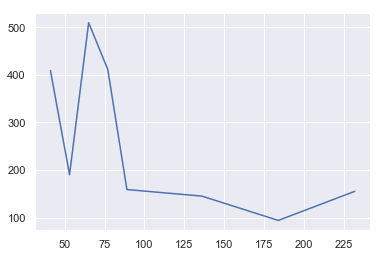

In [76]:
dfs2=pd.DataFrame(columns=['Fk', 'Fs','Vs'],index=weights)
for j, w in enumerate(weights):
    dfs = pd.read_excel("spectral_FFT_scipy.xlsx", sheet_name=j)
    mean = dfs['mean'].values.astype(float)
#     plt.scatter(dfs.index, mean, label = str(w))
    popt, pcov = curve_fit(func_hess, dfs.index, mean, p0=[mean[-1],mean[0]-mean[-1],100])
    dfs2['Fk'][w] = popt[0]
    dfs2['Fs'][w] = popt[0] + popt[1]
    dfs2['Vs'][w] = popt[2]
#     print(popt)
#     plt.plot(dfs.index, func_hess(dfs.index, *popt))

# dfs2
plt.plot(dfs2.index, dfs2['Vs'])
# plt.legend()
plt.show()

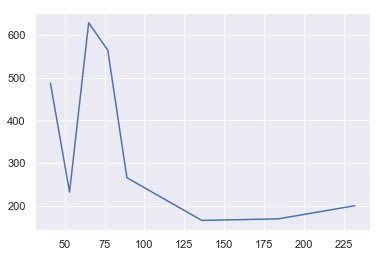

In [75]:
dfs2=pd.DataFrame(columns=['Fk', 'Fs','Vs'],index=weights)
for j, w in enumerate(weights):
    dfs = pd.read_excel("spectral_FFT_scipy.xlsx", sheet_name=j)
    mean = dfs['mean'].values.astype(float)
#     plt.scatter(dfs.index, mean, label = str(w))
    popt, pcov = curve_fit(func_arm, dfs.index, mean, p0=[mean[-1],mean[0]-mean[-1],100])
    dfs2['Fk'][w] = popt[0]
    dfs2['Fs'][w] = popt[0] + popt[1]
    dfs2['Vs'][w] = popt[2]
#     print(popt)
#     plt.plot(dfs.index, func_arm(dfs.index, *popt))

# dfs2
plt.plot(dfs2.index, dfs2['Vs'])
# plt.legend()
plt.show()

In [9]:
%matplotlib qt

# sns.set(rc={'figure.figsize':(10,5)}, font_scale=1.5)
# sns.set_style({'axes.facecolor':'white', 'grid.color': '.8', 'font.family':'Times New Roman'})

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.gcf()
fig.set_size_inches(10, 5)

font = {'family' : 'serif',
        # 'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)

for j, w in enumerate(weights):
    dfs = pd.read_excel("spectral_FFT_scipy.xlsx", sheet_name=j)
    x=dfs.index
    y=dfs['per']
#     xnew=np.linspace(x.min(),x.max(),1000)
#     spl = splrep(x, y)
#     ynew=splev(xnew, spl)
    plt.plot(x, y, linestyle = '--', marker = 'o', markersize = 5, linewidth=2, label = str(w))
#     plt.plot(xnew,ynew)

plt.xlabel(r'Velocity $\mathrm{(mm/min)}$')
plt.ylabel(r'Periodicity $\mathrm{(mm)}$')

plt.legend(shadow = True, ncol = 2, title = r'Mass $\mathrm{(gram)}$', labelspacing = 0.2, columnspacing = 0.2, borderpad = 0.2, prop={'size': 15})
plt.grid(linestyle = '--', linewidth=0.4)
plt.tight_layout()
plt.show()

fig.savefig("Periodicity_20190305.pdf", bbox_inches='tight')

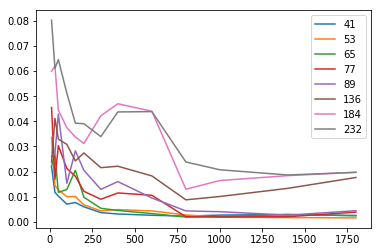

In [49]:
for j, w in enumerate(weights):
    dfs = pd.read_excel("spectral_FFT_scipy.xlsx", sheet_name=j)
    plt.plot(dfs.index, dfs['mag'], label = str(w))

plt.legend()
plt.show()

Using [interpacf](https://github.com/bmorris3/interp-acf) files `ACF0*.py`

In [12]:
%matplotlib qt

for w in weights:
    dfs4 = pd.read_excel("spectral_autocor_interpacf.xlsx", sheet_name=str(w))
    plt.plot(dfs4.index.values.astype(float), dfs4['mag'],label=str(w))
    

plt.ylabel("Amplitude (N)")
# plt.ylabel("Jumping interval (mm)")
plt.xlabel("Speed (mm/min)")
plt.legend(title="Normal force (gram)")
plt.show()

Numpy FFT examples:

In [30]:
%matplotlib qt
# t = np.arange(256)
N = 10000
t=np.linspace(0, 30, num=N)
# print(t)
y=np.sin(t*np.pi*2)
plt.subplot(2, 1, 1)
plt.plot(t,y)
plt.grid()
sp = np.fft.fft(y)

freq = np.fft.fftfreq(N)
# plt.plot(freq, sp.real, label='real')
# plt.plot(freq, sp.imag, label='image')
plt.subplot(2, 1, 2)
plt.semilogx(1/freq[1:N//2], 2.0/N *np.abs(sp[1:N//2]), label='abs')
plt.grid()

# plt.plot(np.abs(sp))

# plt.xlim(0,)
# plt.legend()
plt.show()

from [this](https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/) example:

In [78]:
t = np.linspace(0, 0.5, 500)
s = np.sin(40 * 2 * np.pi * t) + 0.5 * np.sin(90 * 2 * np.pi * t)

plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, s)
plt.show()

In [81]:
fft = np.fft.fft(s)


for i in range(2):
    print("Value at index {}:\t{}".format(i, fft[i + 1]), "\nValue at index {}:\t{}".format(fft.size -1 - i, fft[-1 - i]))


Value at index 0:	(0.000380483492839645-0.060555031761900024j) 
Value at index 499:	(0.00038048349283956173+0.06055503176189987j)
Value at index 1:	(0.0015317714831371843-0.121888085280695j) 
Value at index 498:	(0.001531771483137545+0.12188808528069514j)


In [82]:
fft = np.fft.fft(s)
T = t[1] - t[0]  # sample rate
N = s.size

# 1/T = frequency
f = np.linspace(0, 1 / T, N)

plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.bar(f[:N // 2], np.abs(fft)[:N // 2] * 1 / N, width=1.5)  # 1 / N is a normalization factor
plt.show()

In [63]:

# Number of samplepoints
N = 10000
# sample spacing
T = 1.0
dt = T / N
x = np.linspace(0.0, T, N)
y = np.sin((1/0.3) * 2.0*np.pi*x) + 0.5*np.sin((1/0.1) * 2.0*np.pi*x)

plt.subplot(2, 1, 1)
plt.plot(x,y)

yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*dt), N//2)

# fig, ax = plt.subplots()
plt.subplot(2, 1, 2)
plt.semilogx(xf[1:], 2.0/N * np.abs(yf[1:N//2]))
plt.grid()
plt.show()

In [80]:

t0 = 0
t1 = 1
n_samples = 10000
dt =(t1 -t0)/n_samples

xs = np.linspace(t0, t1, n_samples)
# Generate signal with amplitudes 7 and 3
ys = 7*np.sin(15 * 2 * np.pi * xs) + 3*np.sin(13 * 2 * np.pi * xs)

plt.subplot(2, 1, 1)
plt.plot(xs,ys)

np_fft = np.fft.fft(ys)
amplitudes = 2/n_samples * np.abs(np_fft) 


# frequencies = np.linspace(0.0, 1.0/(2.0*dt), n_samples//2)
frequencies = np.fft.fftfreq(n_samples) * n_samples * 1/(t1-t0)

plt.subplot(2, 1, 2)
# plt.semilogx(frequencies, amplitudes[:len(np_fft)//2])
plt.semilogx(frequencies[:len(frequencies)//2], amplitudes[:len(np_fft)//2])


plt.show()

In [78]:
# from here https://stackoverflow.com/a/53434508/4999991

import numpy as np
import matplotlib.pyplot as plt

t0 = 0
t1 = 1
n_samples = 1000

xs = np.linspace(t0, t1, n_samples)
# Generate signal with amplitudes 7 and 3
ys = 7*np.sin(15 * 2 * np.pi * xs) + 3*np.sin(13 * 2 * np.pi * xs)

plt.subplot(2, 1, 1)
plt.plot(xs,ys)

np_fft = np.fft.fft(ys)
amplitudes = 2/n_samples * np.abs(np_fft) #This gives wrong results

frequencies = np.fft.fftfreq(n_samples) * n_samples * 1/(t1-t0)

plt.subplot(2, 1, 2)
plt.plot(frequencies[:len(frequencies)//2], amplitudes[:len(np_fft)//2])
plt.show()